In [1]:
import pandas as pd
import os
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(".."))
from pathlib import Path
from dateutil.parser import parse
import seaborn as sns
import matplotlib.pyplot as plt 
from pivottablejs import pivot_ui
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.cloud import bigquery

In [2]:
pd.set_option('display.max_columns', None) # or other number has no effect
%load_ext autoreload
%autoreload 2

In [3]:
min_date='2013-01-01'
max_date='2025-01-31'

In [4]:
    query = f"""
        with clean_data as (
                select * EXCEPT (store_number, zip_code, category, vendor_number, county_number),
                CAST(store_number AS NUMERIC) as store_number ,
                CAST(zip_code AS NUMERIC) as zip_code ,
                CAST(category AS NUMERIC) as category,
                CAST(vendor_number AS NUMERIC) as vendor_number
                from `bigquery-public-data.iowa_liquor_sales.sales`
                where date >= '{min_date}' and date <= '{max_date}'
                --and CAST(vendor_number AS NUMERIC) in (260,421,65,370,85,434,35,301,259,115,395,55,420,205,380,192,297,300,255,389)
                ORDER BY date ASC
        ),
        distinct_vendor as (
                select
                CAST(vendor_number AS NUMERIC) as vendor_number,
                ARRAY_TO_STRING(ARRAY_AGG(vendor_name ORDER BY date DESC LIMIT 1),"") as vendor_name
                from `bigquery-public-data.iowa_liquor_sales.sales`
                group by 1
        ),
        distinct_category as (
                select
                CAST(category AS NUMERIC) as category,
                ARRAY_TO_STRING(ARRAY_AGG(category_name ORDER BY date DESC LIMIT 1),"") as category_name
                from `bigquery-public-data.iowa_liquor_sales.sales`
                group by 1
        ),
        distinct_store as (
                select
                CAST(store_number AS NUMERIC) as store_number,
                ARRAY_TO_STRING(ARRAY_AGG(store_name ORDER BY date DESC LIMIT 1),"") as store_name
                from `bigquery-public-data.iowa_liquor_sales.sales`
                group by 1
        ), clean_data2 as (
        select
                cd.* EXCEPT (vendor_name, category_name, store_name),
                dv.vendor_name,
                dc.category_name,
                ds.store_name
        from clean_data cd
        left join distinct_vendor dv on cd.vendor_number = dv.vendor_number
        left join distinct_category dc on cd.category = dc.category
        left join distinct_store ds on cd.store_number = ds.store_number
        ), group_and_others as (
        SELECT date,
        case when county in ('POLK','LINN','SCOTT','BLACK HAWK','JOHNSON') then county else 'OTHER' END AS county, #'POTTAWATTAMIE','DUBUQUE','STORY','WOODBURY','DALLAS'
        CASE
        WHEN category_name like '%RUM%' THEN 'RUM'
        WHEN category_name like '%VODKA%' THEN 'VODKA'
        WHEN category_name like '%WHISK%' or  category_name like '%SCOCH%' THEN 'WHISKY'
        WHEN category_name like '%TEQUILA%' or category_name like '%MEZCAL%' THEN 'TEQUILA_MEZCAL'
        WHEN category_name like '%LIQUEUR%' THEN 'LIQUEURS'
        WHEN category_name like '%GIN%' THEN 'GIN'
        else 'OTROS'
        end as category_name,
        case when vendor_name in ('SAZERAC COMPANY  INC','DIAGEO AMERICAS','HEAVEN HILL BRANDS','LUXCO INC','JIM BEAM BRANDS','FIFTH GENERATION INC','PERNOD RICARD USA','MCCORMICK DISTILLING CO.','BACARDI USA INC','E & J GALLO WINERY') then vendor_name else 'OTHER' END as vendor_name,
        sum(bottles_sold) as bottles_sold
        FROM clean_data2
        group by 1,2,3,4
        ), summary as (
        select
        * EXCEPT (vendor_name)
        from group_and_others
        where lower(vendor_name) like '%bacardi%'
        ), combinations as (
        SELECT
          *
          FROM UNNEST(GENERATE_DATE_ARRAY('{min_date}', '{max_date}', INTERVAL 1 DAY)) as date
          cross join (select distinct category_name from summary) a
          cross join (select distinct county from summary) b
          ), data_combinations as (
        select c.*,
        coalesce(s.bottles_sold,0) as bottles_sold
          from combinations c
          left join summary s on c.date = s.date and c.category_name = s.category_name and c.county = s.county
          )
          select date, category_name, county,
          sum(bottles_sold) as bottles_sold
           from data_combinations
           group by 1,2,3
           order by date asc, county asc, category_name asc

    """


In [5]:
gcp_project = 'lewagon-bootcamp-2025'

In [6]:
client = bigquery.Client(project=gcp_project)
query_job = client.query(query)
result = query_job.result()
df_bq = result.to_dataframe()

In [7]:
df = df_bq.copy()

In [8]:
df.shape

(185388, 4)

In [9]:
#df = df.query("bottles_sold > 0")

In [123]:
df2 = df.query("category_name == 'GIN' and county == 'LINN'")

In [44]:
#data_path = '../data/raw/data.csv'

In [45]:
#df = pd.read_csv(data_path)

In [46]:
#df['bottles_sold'] = df['bottles_sold'].fillna(0)

In [47]:
# Setting dates as the index
df.date = pd.to_datetime(df.date)

AttributeError: 'DataFrame' object has no attribute 'date'

In [ ]:
df.set_index(['date'], inplace=True)

In [124]:
df_demand = df2.resample("ME")[["bottles_sold"]].sum()

<Axes: xlabel='date'>

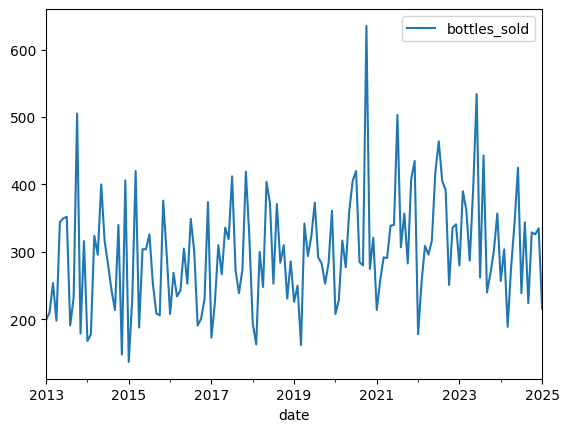

In [125]:
df_demand.plot()

In [126]:
#df_demand['bottles_sold'] = df_demand['bottles_sold'].fillna(1)

### Decomposition

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose

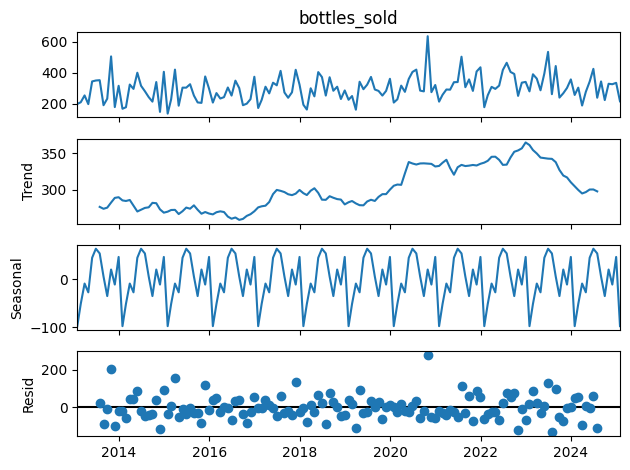

In [128]:
result_add = seasonal_decompose(df_demand["bottles_sold"], model='additive', period= 12)
result_add.plot();

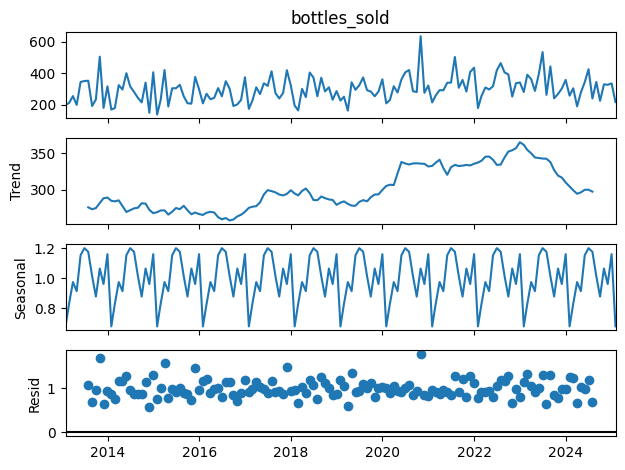

In [129]:
result_mul = seasonal_decompose(df_demand["bottles_sold"], model='multiplicative', period= 12)
result_mul.plot();

In [130]:
m=12

### Stationarity

In [131]:
from statsmodels.tsa.stattools import adfuller

In [132]:
def adf_test(series):
    result = adfuller(series.dropna())  
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("✅ The data is stationary.")
    else:
        print("❌ The data is NOT stationary. Differencing needed.")

adf_test(df_demand)  # Check original data

ADF Statistic: -1.4827339994913065
p-value: 0.5420346376042218
❌ The data is NOT stationary. Differencing needed.


In [133]:
from statsmodels.tsa.stattools import adfuller

In [134]:
df_train = df_demand[df_demand.index.year < 2024].copy()
df_test = df_demand[df_demand.index.year >= 2024].copy()

In [135]:
df_demand_diff = df_train.diff().dropna()
adf_test(df_demand_diff)
df_demand_diff2 = df_demand.diff().diff()
df_demand_diff2 = df_demand_diff2.dropna()
adf_test(df_demand_diff2)

df_demand_season_diff = df_demand.diff(12).dropna()
adf_test(df_demand_season_diff)

ADF Statistic: -7.571080059202946
p-value: 2.84022146127849e-11
✅ The data is stationary.
ADF Statistic: -10.05977076795256
p-value: 1.3431203897197585e-17
✅ The data is stationary.
ADF Statistic: -3.461578246152157
p-value: 0.009030446749577467
✅ The data is stationary.


In [136]:
d = 2

### Autocorrelation

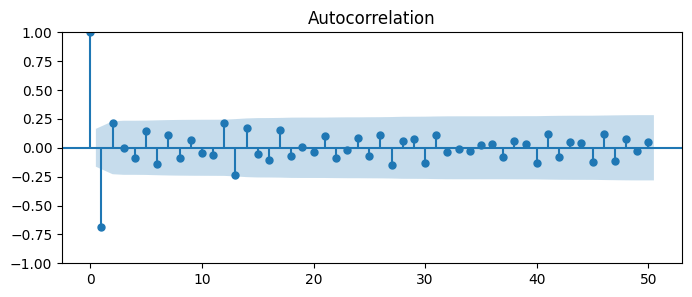

In [137]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_demand_diff2, lags=50, ax=ax)
plt.show()

In [138]:
q = 2

### Autoregresion

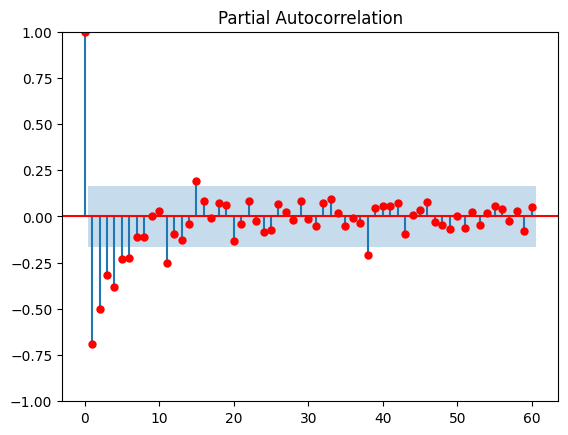

In [139]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_demand_diff2, lags=60, c='r');

In [140]:
p = 6

## ARIMA

In [141]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#model = SARIMAX(df_monthly, order=(p,d,q), seasonal_order=(P,D,Q,m))
model = SARIMAX(df_demand_diff2, order=(p,0,q), seasonal_order=(1,1,1,m))
sarima_result = model.fit(maxiter=1000)

/home/renanhilinski/.pyenv/versions/3.10.6/envs/liquor_demand_forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/tmp/ipykernel_395572/3528872888.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(df_demand_diff2.index[-1], periods=12, freq="M")


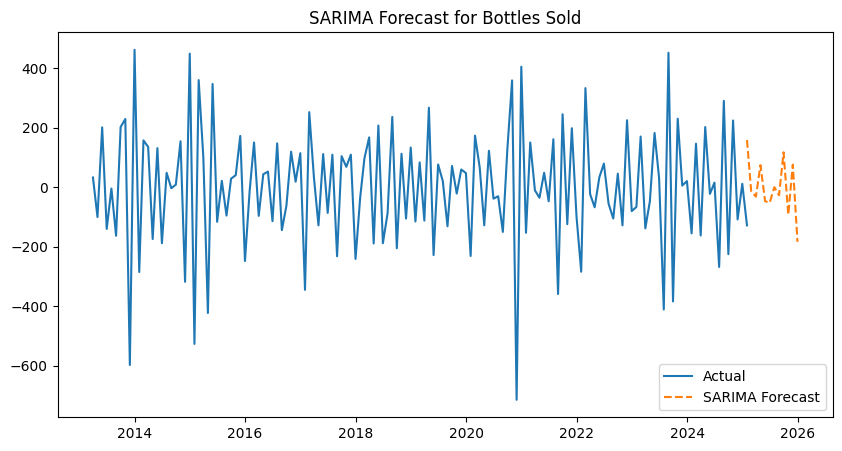

In [142]:
forecast = sarima_result.get_forecast(steps=12)
forecast_index = pd.date_range(df_demand_diff2.index[-1], periods=12, freq="M")
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Plot Actual vs Forecast
plt.figure(figsize=(10, 5))
plt.plot(df_demand_diff2, label="Actual")
plt.plot(forecast_series, label="SARIMA Forecast", linestyle="dashed")
plt.legend()
plt.title("SARIMA Forecast for Bottles Sold")
plt.show()

In [143]:
# Forecast for the next 12 periods on the differenced data
forecast_diff2 = sarima_result.get_forecast(steps=12)
forecast_diff2_values = forecast_diff2.predicted_mean

# Create forecast index for the next 12 months
forecast_index = pd.date_range(start=df_train.index[-1] + pd.DateOffset(months=1), 
                               periods=12, freq="M")

/tmp/ipykernel_395572/1037115353.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df_train.index[-1] + pd.DateOffset(months=1),


In [144]:
# Reverse the second differencing (d=2 → d=1)
# The forecast_diff2_values should be added to the last value of the first differenced data
last_diff1 = df_demand.diff().dropna().iloc[-1]  # Last value from the first differenced data

# Apply cumulative sum to forecasted differenced values to reverse second differencing
forecast_diff1_values = forecast_diff2_values.cumsum() + float(last_diff1)

# Reverse the first differencing (d=1 → Original Scale)
# Use the last actual value of the original series to reverse the first differencing
last_value = df_demand.iloc[-1]  # Last actual value of the original data
forecast_original = forecast_diff1_values.cumsum() + float(last_value)

# Slice to ensure forecast only contains the last 12 values
forecast_original = forecast_original[-12:]


/tmp/ipykernel_395572/1307668094.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  forecast_diff1_values = forecast_diff2_values.cumsum() + float(last_diff1)
/tmp/ipykernel_395572/1307668094.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  forecast_original = forecast_diff1_values.cumsum() + float(last_value)


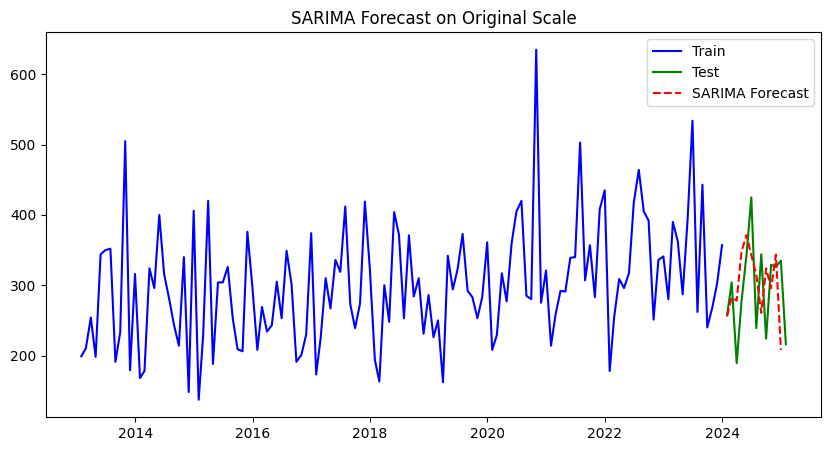

In [145]:
# Plotting the forecast alongside the original data
plt.figure(figsize=(10, 5))
plt.plot(df_train, label="Train", color="blue")
plt.plot(df_test, label="Test", color="green")
plt.plot(forecast_index, forecast_original, label="SARIMA Forecast", linestyle="dashed", color="red")
plt.title("SARIMA Forecast on Original Scale")
plt.legend()
plt.show()


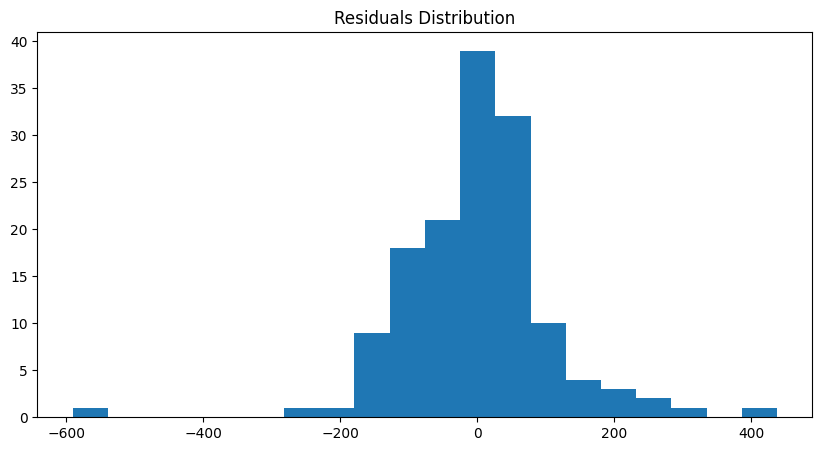

In [146]:
residuals = sarima_result.resid
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.title("Residuals Distribution")
plt.show()

ARIMA(p=2,d=1,q=1)

In [39]:
df_test

,bottles_sold
date,
2024-01-31,63951
2024-02-29,68090
2024-03-31,72376
2024-04-30,77131
2024-05-31,86765
2024-06-30,84672
2024-07-31,80444
2024-08-31,80381
2024-09-30,68978
